# Response function plugin for Pastas

This notebook shows usage of a custom response function from the responses plugin for
Pastas.

In [1]:
import pandas as pd
import pastas as ps

import pastas_plugins as pp
from pastas_plugins import responses

In [2]:
pp.show_plugin_versions()

pastas_plugins version      : 0.3.4
- cross_correlation version : not available (check dependencies)
- modflow version           : not available (check dependencies)
- pest version              : 0.0.5
- reservoirs version        : 0.1.0
- responses version         : 0.2.0

Note: To install missing dependencies use `pip install pastas-plugins[<plugin-name>]`


/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
index = pd.date_range("2014-01-01", "2024-01-01", freq="D")
df = pd.read_csv("data/aftopping.csv", index_col=0, parse_dates=True)
stress = (df["Precipitation"] - df["Evaporation"]).multiply(1e3)


def get_model(rfunc: ps.rfunc.RfuncBase, oseries: pd.Series | None = None) -> ps.Model:
    # Create a Pastas model
    oseries = pd.Series(0.0, stress.index) if oseries is None else oseries

    ml = ps.Model(oseries)

    # Create a stress model with recharge response
    sm = ps.StressModel(stress, rfunc=rfunc, name="sm", settings="evap")
    ml.add_stressmodel(sm)

    return ml


ml_synth = get_model(ps.Exponential())
ml_synth.set_parameter("sm_A", initial=0.1)
ml_synth.set_parameter("sm_a", initial=100.0)
ml_synth.set_parameter("constant_d", initial=5.0)
head = ml_synth.simulate()

Model is not optimized yet, initial parameters are used.


## The Theis response function

The Theis response function is based on the analytical solution for pumping between two
infinitely long ditches.

In [4]:
ml = get_model(responses.Theis(), head)
ml.solve()

Fit report Simulation              Fit Statistics
nfev    58                     EVP          96.02
nobs    5351                   R2            0.96
noise   False                  RMSE          0.01
tmin    2002-06-10 00:00:00    AICc     -46532.24
tmax    2017-02-01 00:00:00    BIC      -46505.91
freq    D                      Obj           0.45
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (4 optimized)
               optimal     initial  vary
sm_A          0.038215    0.258227  True
sm_a        198.906792  100.000000  True
sm_b          0.162112    0.001000  True
constant_d    4.998249    5.057874  True


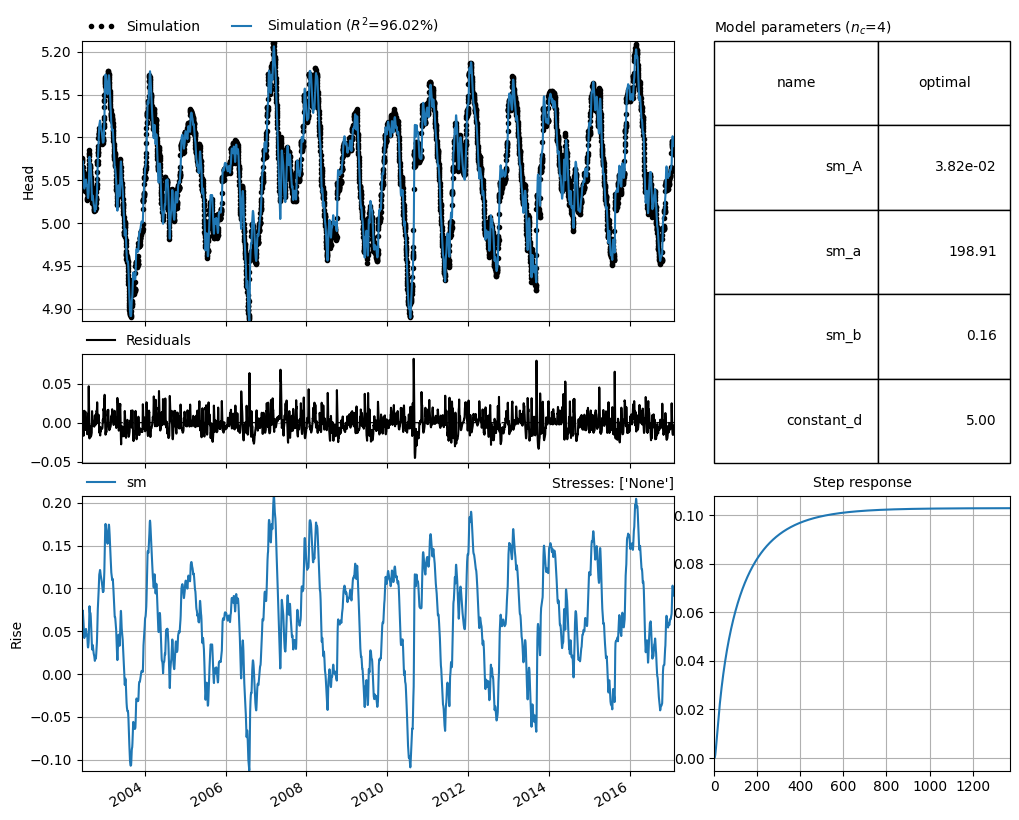

In [5]:
axes = ml.plots.results()

## The Edelman response function

In [6]:
ml_em = get_model(responses.Edelman(), head)
ml_em.solve()

Fit report Simulation              Fit Statistics
nfev    32                     EVP           0.56
nobs    5351                   R2            0.01
noise   False                  RMSE          0.06
tmin    2002-06-10 00:00:00    AICc     -29314.06
tmax    2017-02-01 00:00:00    BIC      -29300.90
freq    D                      Obj          11.17
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (2 optimized)
             optimal   initial  vary
sm_beta     0.006867  1.000000  True
constant_d  5.051175  5.057874  True

Warnings! (2)
Response tmax for 'sm' > than calibration period.
Response tmax for 'sm' > than warmup period.


<Axes: ylabel='Head'>

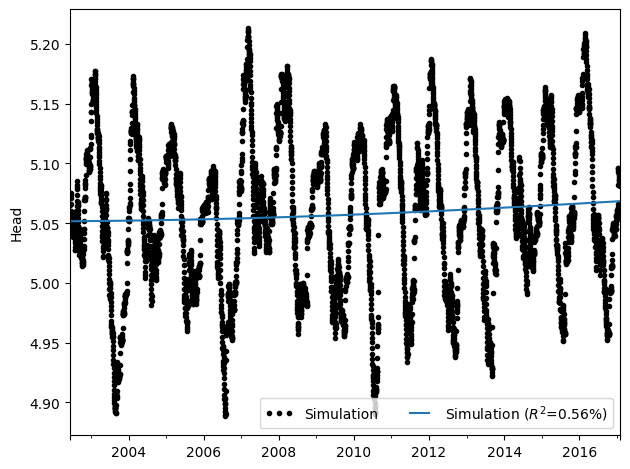

In [7]:
ml_em.plot()